# E-mail network analysis

## Mail Graph creation

### Importing the necessary packages
First of all we begin by importing the necessary packages. The necessary ones are `networkx` and `matplotlib.pyplot`. The first is used for network analysis and the second for plotting.

In [1]:
import networkx as nx  # Core network analysis package
import numpy as np  # Core numeric package
import matplotlib.pyplot as plt  # Core plotting package
import dzcnapy_plotlib as dzcnapy  # Optional library containing pre-made plotting options
import csv  # Package for csv I/O
from collections import Counter  # Import only the single object Counter

### Reading data files
We open the data in csv format (list of edges representing mail comunication) and create the corresponding **directed** graph, called `mail_DG`

In [2]:
with open("email-Eu-core.csv") as infile:
    csv_reader = csv.reader(infile)
    mail_DG = nx.DiGraph(csv_reader)

#print(DG.nodes(data = True))
#print(DG.edges(data = True))

Then we read the second file, which contains the department to which every node belongs, and add the information to the nodes in the graph. The result is a _directed graph_ with an attribute called `department` (with int values from 0 to 41) for each node.
There are 1005 nodes - or people - divided into 42 classes (or departments).

In [3]:
# We create a dictionary of dictionaries, having as key the node label (number between 0 and 1004)
# and with value a dictionary with the name of the attribute ('deprtment') as key and as associated value
# the department number of the node.
# NOTE: this structure is necessary because there could be more attributes, and it is required by the function
# set_node_attributes in networkx

with open("email-Eu-core-department-labels.csv") as infile:
    csv_reader = csv.reader(infile)
    attr_dict_dict = {rows[0]: {'department': int(rows[1])} for rows in csv_reader}

#print(attr_dict_dict)

In [4]:
nx.set_node_attributes(mail_DG, attr_dict_dict)

#print(DG.nodes(data = True))

###### Cleaning the graph
Let us remove the self-loops from the graph (sinche those represent the mail to one-self, irrelevant to the analysis):

In [5]:
self_loops = mail_DG.selfloop_edges()
mail_DG.remove_edges_from(self_loops)

We also create an undirected version of the graph, useful for some manipulation. This requires a simple casting.

In [6]:
mail_G = mail_DG.to_undirected()  # Undirected version of graph used for the computation of clustering coefficient

In [7]:
print("DIRECTED VERSION OF THE GRAPH:")
print(nx.info(mail_DG) + "\n")

print("UNDIRECTED VERSION:")
print(nx.info(mail_G))

DIRECTED VERSION OF THE GRAPH:
Name: 
Type: DiGraph
Number of nodes: 1005
Number of edges: 24929
Average in degree:  24.8050
Average out degree:  24.8050

UNDIRECTED VERSION:
Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16064
Average degree:  31.9682


## Department graph creation
The analysis of the department graph (based on the interactions between their elements) could be of interest.
We create the graph by adding all departments as nodes, and then adding edges between them based on the number of (undirected) edges between their elements.

In [8]:
# Graph initialization with just the departments as nodes

dep_G = nx.Graph()
for node in mail_DG.nodes(data = True):
    label, attr_dict = node
    dep_G.add_node(attr_dict["department"])
    
#print(nx.info(dep_G))

In [9]:
# For each edge in the undirected mail graph, identify the department of bot source and target
# and create an edge between those departments in the departments graph if not already existing.
# Otherwise add a weight unit to the existing edge between departments.
for edge in mail_G.edges(data=True):
    source, target, edg_attr = edge
    source_dep = attr_dict_dict[source]['department']
    targ_dep = attr_dict_dict[target]['department']
    if dep_G.has_edge(source_dep, targ_dep) == False:
        dep_G.add_edge(source_dep, targ_dep, weight = 1)
    else:
        edges = dep_G.edges
        w = edges[source_dep, targ_dep]['weight']
        dep_G.add_edge(source_dep, targ_dep, weight = w+1)

Note that the result is an undirected weighted graph with 42 nodes:

In [10]:
print(nx.info(dep_G))

Name: 
Type: Graph
Number of nodes: 42
Number of edges: 679
Average degree:  32.3333


### Graph export
To visualize the graphs, we export them in `graphml` format to import them in _Gephi_.

In [11]:
nx.write_graphml(mail_DG, "emails_w_attr_dep.graphml")
nx.write_graphml(dep_G, "departments_weighted.graphml")

## Networks Analysis

### Connected components and Giant Component
#### Mail network
First, we analyze the composition of the network by searching for the weakly and strongly connected components in the directed mail graph.
Note that, clearly, the number of weakly connected components of the directed mail graph is the same as the number of connected components of the undirected mail graph.

In [12]:
n_weak_conn_comp = nx.number_weakly_connected_components(mail_DG)
n_strong_conn_comp = nx.number_strongly_connected_components(mail_DG)
n_conn_comp = nx.number_connected_components(mail_G)

print("# of connected components: " + str(n_conn_comp))
print("# of weakly connected components: " + str(n_weak_conn_comp))
print("# of strongly connected components: " + str(n_strong_conn_comp))

# of connected components: 20
# of weakly connected components: 20
# of strongly connected components: 203


Is there a giant component in the graph?

In [13]:
# Create the list of components (subgraphs)
connected_components_generator = (mail_DG.subgraph(c) for c in nx.connected_components(mail_G))
conn_comp_list = list(connected_components_generator)

# Compute total size and order to see the proportion in the components
tot_nodes_n = mail_DG.order()
tot_directed_edges_n = mail_DG.size()
tot_undirected_edges_n = mail_G.size()

# Initialize variables to search for the biggest component:
max_order = 0
max_order_index = 0

# Scan through components, find the one with max order and print some info for the first bunch
for (i, component) in zip(range(len(conn_comp_list)), conn_comp_list):
    n_nodes_comp = component.order()
    n_directed_edges_comp = component.size()   
    
    if n_nodes_comp > max_order:
        max_order = n_nodes_comp
        max_order_index = i
    
    relative_order = n_nodes_comp/tot_nodes_n
    relative_size = n_directed_edges_comp/tot_directed_edges_n
    
    if i < 3:
        print("COMPONENT #" + str(i) + ":")
        print("# of nodes: " + str(n_nodes_comp))
        print("# of edges: " + str(n_directed_edges_comp))
        print("Relative Order (proportion of nodes):", relative_order)
        print("Relative Size (proportion of edges):", relative_size)
        print()

print("...")

COMPONENT #0:
# of nodes: 986
# of edges: 24929
Relative Order (proportion of nodes): 0.981094527363184
Relative Size (proportion of edges): 1.0

COMPONENT #1:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

COMPONENT #2:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

...


Yes.
The other 19 components are actually isolated nodes that communicate at most with themselves (self-loops).

In [14]:
giant_component_mail_DG = conn_comp_list[0]
gc_mail_DG = giant_component_mail_DG

For the analysis of the mail network, we can in some instances use just the giant component. This will enable us to find measures like distances without risking to find infinite-length (not connected) paths.

### Measures - degree

We first extrapolate the degree of all nodes, we find the max, we compute the frequency for each degree..

In [110]:
node_and_degrees = mail_DG.degree  # Iterator over 2-tuples (node, degree)

node_degrees = list(deg for _, deg in mail_DG.degree)  # List of degrees

In [111]:
deg_counter = Counter(node_degrees)

degrees = list(sorted(deg_counter.keys()))
deg_freq = list(deg_counter[deg] for deg in degrees)

max_degree = max(degrees)
print("Max degree: " + str(max_degree))

log_degrees = np.log(degrees)
log_deg_freq = np.log(deg_freq)

Max degree: 544


/Users/claudio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


..and then we plot the distribution.

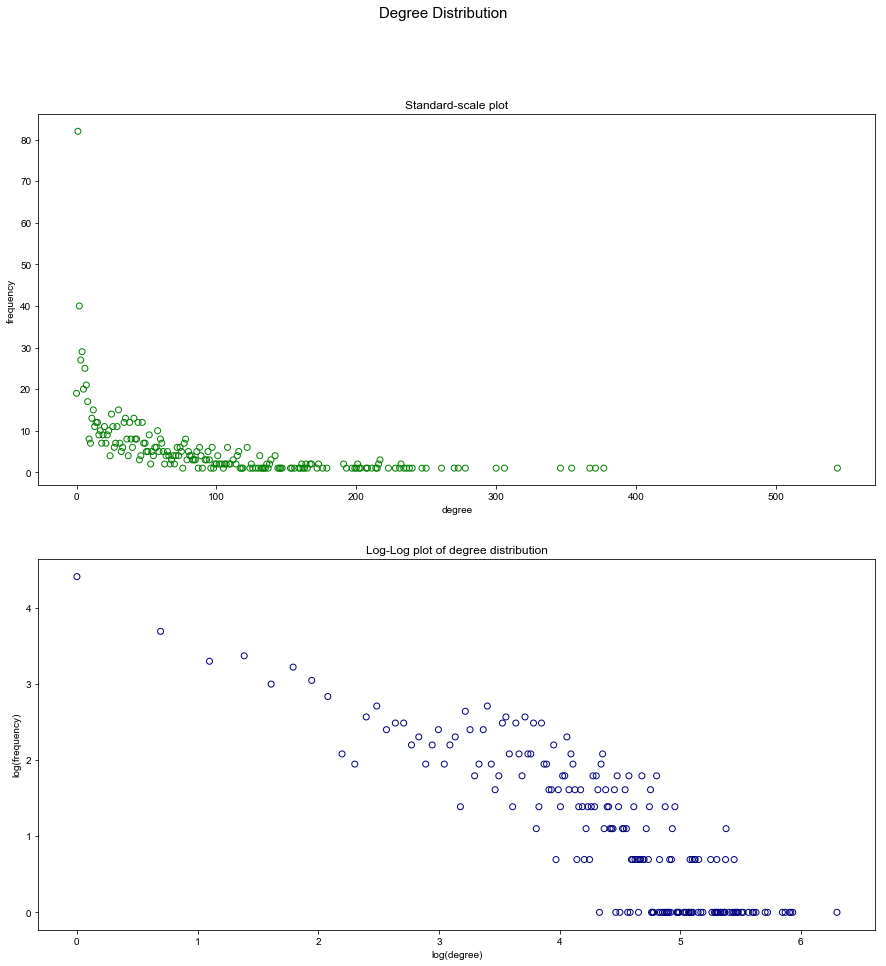

In [112]:
# Create a Figure divided in two Axes (subplots)
fig, (ax, ax_log) = plt.subplots(2, 1)
fig.set_size_inches(15, 15)
fig.suptitle("Degree Distribution", fontsize = 15)

# In the first Axis draw the standard-scale distribution of degrees
ax.set_xlabel('degree')
ax.set_ylabel('frequency')
ax.set_title("Standard-scale plot")
ax.scatter(degrees, deg_freq, marker = 'o', facecolors='none', edgecolors='#008000', label = 'Degree distribution')

# In the second Axis draw the log-log distribution of degrees
ax_log.set_xlabel('log(degree)')
ax_log.set_ylabel('log(frequency)')
ax_log.set_title("Log-Log plot of degree distribution")
ax_log.scatter(log_degrees, log_deg_freq, marker = 'o', facecolors='none', edgecolors='#000080', label = 'log-log distribution')

# Save the figure as png and plot it
#legend()  # No need for the legend
plt.savefig("degree_distribution.png")
plt.show()

# END

In [16]:
print("density of email network:", str(nx.density(mail_DG)))
print("density of department network:", str(nx.density(dep_G)))

density of email network: 0.024706150522288955
density of department network: 0.7886178861788617


In [17]:
nx.average_clustering(mail_G)

0.3993549664221539

In [18]:
central_node = 160
CC_dict = nx.clustering(G)
CC = sum(CC_dict.values())/len(CC_dict.values())
print("CC:", CC)

cc_central_node = nx.clustering(G, str(central_node))
betweenness = nx.betweenness_centrality(DG, normalized = False)
print("clustering coefficient:", str(cc_central_node))
print("betweenness of nodes:", str(betweenness))
type(betweenness)

NameError: name 'G' is not defined

In [ ]:
lis = []
for key in betweenness.keys():
    lis.append(betweenness[key])

plt.plot(range(len(lis)), lis)

In [ ]:
print("betweenness of departments:", str(nx.betweenness_centrality(DG_only_dep, normalized = False)))

In [ ]:
lista = nx.degree(DG)
assortativity = np.zeros(len(degrees))
avg_neighbor_deg = nx.average_neighbor_degree(DG)
for i in range(1, len(assortativity)):
    avg = 0
    num = 0
    summ = 0
    for node_str, degree in lista:
        if degree == i:
            num += 1
            summ += avg_neighbor_deg[node_str]
    avg = summ/num if num is not 0 else 0
    assortativity[i] = avg

print(assortativity)

In [ ]:
print(nx.degree_assortativity_coefficient(DG))
plt.scatter(range(len(assortativity)), assortativity)

In [ ]:
max_distance = 0
max_source = 0
for source, dictionary in nx.shortest_path_length(G):
    max_distance = max(dictionary.values()) if max(dictionary.values()) > max_distance else max_distance
    max_source = int(source) if int(source) > max_source else int(source)

print(max_distance)
print(max_source)

In [ ]:
distances = np.zeros(max_distance+1)
sources = np.arange(max_source+1)

for source, dictionary in nx.shortest_path_length(G):
    key = 0
    while key < int(source):
        if str(key) in dictionary:
            del dictionary[str(key)]
        key = key + 1
    count = Counter(dictionary.values())
    for i in range(max_distance+1):
        distances[i] = distances[i] + count[i]

print(distances)

In [ ]:
plt.plot(distances, linestyle='dotted', color = 'red')
plt.scatter(range(len(distances)), distances, linestyle='dotted', color = 'blue')
plt.savefig("distance_distribution.png")
tot_distances = sum(distances)
weighted_sum = 0
for i in range(len(distances)):
    weighted_sum += i*distances[i]

average_distance = weighted_sum/tot_distances
average_distance

In [ ]:
nx.average_shortest_path_length(largest_cc)

In [ ]:
nx.diameter(largest_cc.to_undirected())

In [ ]:
nx.radius(largest_cc.to_undirected())

In [ ]:
eccentricities = nx.eccentricity(largest_cc.to_undirected())
eccentricities

In [ ]:
min(eccentricities.values())

In [ ]:
print(eccentricities[str(central_node)])